# DIABETIC RETINOPATHY DETECTION USING EFFICIENTNET B3



In [ ]:

nr_seed = 11
import numpy as np
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

In [ ]:

!pip install -U '../input/install/efficientnet-0.0.3-py2.py3-none-any.whl'
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from efficientnet import EfficientNetB3
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam
from keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.color import rgb2hsv, lab2lch

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

Processing /kaggle/input/install/efficientnet-0.0.3-py2.py3-none-any.whl


Using TensorFlow backend.


In [ ]:
WIDTH= 320
HEIGHT = 320
BATCH_SIZE = 32

# Loading & Merging

In [ ]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels_cropped.csv')
duplicates = pd.read_csv('../input/aptos-trained-weights/inconsistent.csv')
print(new_train.shape)
print(old_train.shape)
print(duplicates.shape)

(3662, 2)
(35108, 4)
(60, 1)


In [ ]:
for img_name in duplicates['id_code'].values:
    new_train = new_train[new_train['id_code'] != img_name]
print(new_train.shape)

(3602, 2)


In [ ]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()


new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

id_code  diagnosis
0  ../input/diabetic-retinopathy-resized/resized_...          0
1  ../input/diabetic-retinopathy-resized/resized_...          0
2  ../input/diabetic-retinopathy-resized/resized_...          0
3  ../input/diabetic-retinopathy-resized/resized_...          0
4  ../input/diabetic-retinopathy-resized/resized_...          1


Using new Data for validation and Old data for training£

In [ ]:
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35108, 2)
(3602, 2)


### Process Images

In [ ]:
def crop_image1(img,tol=7):
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol

        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)

        return img

def circle_crop(img):

    img = crop_image_from_gray(img)
    height, width, depth = img.shape

    x = int(width/2)
    y = int(height/2)
    r = np.amin((x,y))

    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x,y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)

    return img

def preprocess_image(image_path, width=320, height=320, new_data=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if new_data:
        img = crop_image_from_gray(img)
    img = cv2.resize(img, (width,height))
    #img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), 20) ,-4 ,128)

    return img

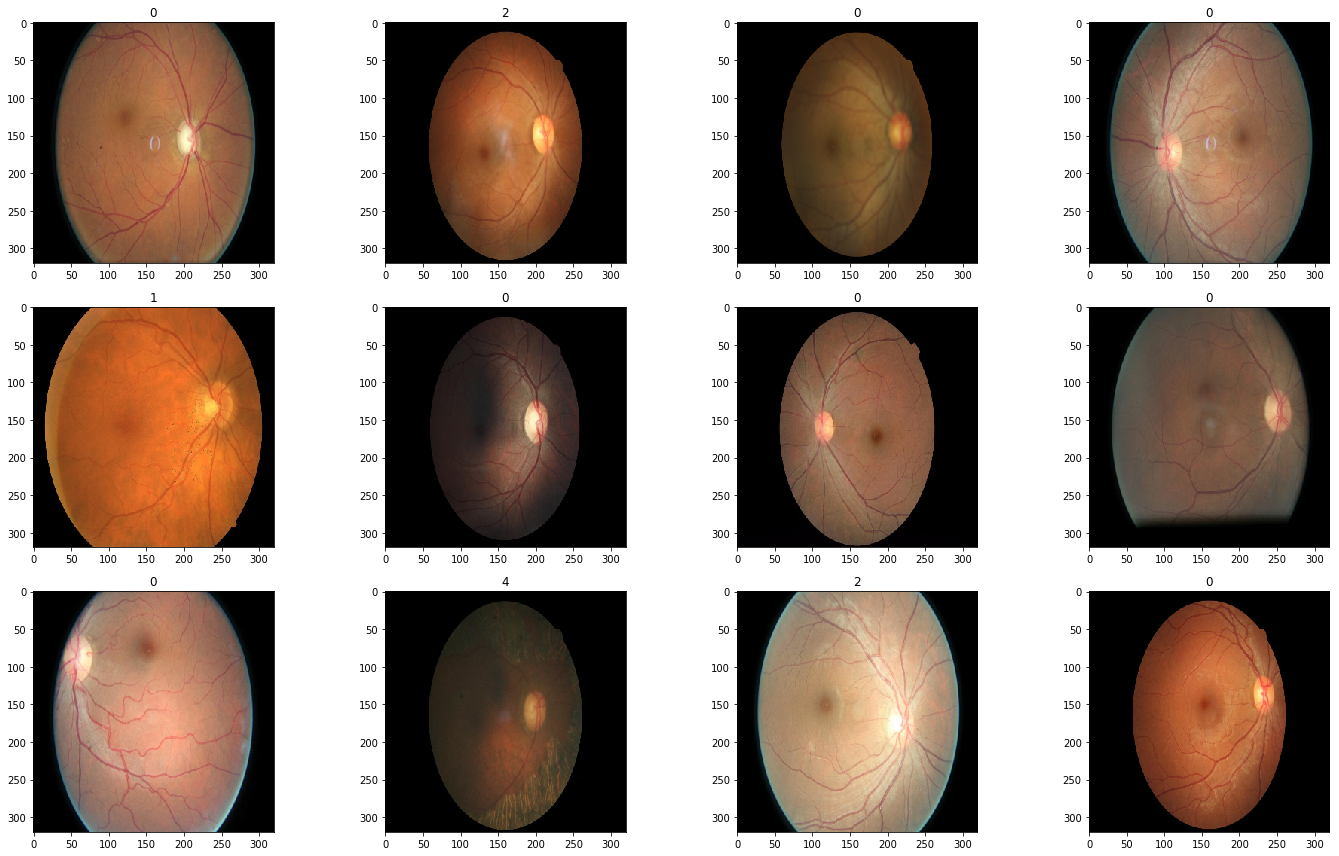

In [ ]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = preprocess_image(f'{image_path}', width=WIDTH, height=HEIGHT)
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)

    plt.tight_layout()

display_samples(train_df)

# Processing Images

In [ ]:
N = val_df.shape[0]
x_val = np.empty((N, HEIGHT, WIDTH, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        height=HEIGHT, width=WIDTH, new_data=True
    )

In [ ]:
y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(35108, 5)
(3602, 320, 320, 3)
(3602, 5)


# Creating multilabels



In [ ]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (35108, 5)
Y_val multi: (3602, 5)


In [ ]:
y_train = y_train_multi
y_val = y_val_multi

In [ ]:
del new_train
del old_train
del val_df
gc.collect()

27259

# Creating keras callback for QWK



In [ ]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1

        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred,
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")

        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [ ]:
def create_datagen():
    return ImageDataGenerator(
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range= 0.3,
        brightness_range=(0.5, 2),
        fill_mode='constant',
        cval=0
    )

Check the differenct kinds of augmentations on the pictures.

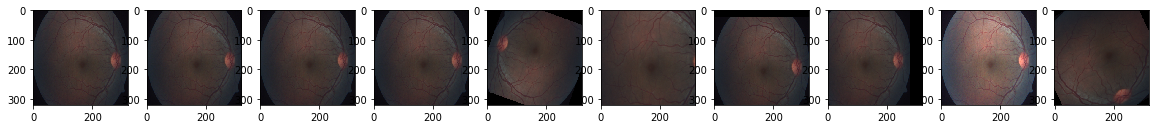

In [ ]:
fig, ax = plt.subplots(1, 10, figsize=(20, 10))
ax = ax.ravel()

img = x_val[0].reshape(1,x_val[0].shape[0],x_val[0].shape[1], x_val[0].shape[2])

ax[0].imshow(img[0].astype('uint8'))
ax[1].imshow(next(ImageDataGenerator().flow(img))[0].astype('uint8'))
ax[2].imshow(next(ImageDataGenerator(horizontal_flip=True, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[3].imshow(next(ImageDataGenerator(vertical_flip=True,fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[4].imshow(next(ImageDataGenerator(rotation_range=360, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[5].imshow(next(ImageDataGenerator(zoom_range= (0.65,1), fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[6].imshow(next(ImageDataGenerator(height_shift_range=0.15, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[7].imshow(next(ImageDataGenerator(width_shift_range=0.15, fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[8].imshow(next(ImageDataGenerator(brightness_range=(0.5, 2), fill_mode='constant', cval=0).flow(img))[0].astype('uint8'))
ax[9].imshow(next(ImageDataGenerator(horizontal_flip=True,
                                     vertical_flip=True,
                                     rotation_range=360,zoom_range= (0.65,1),
                                     brightness_range=(0.5, 2),
                                     fill_mode='constant',cval=0).flow(img))[0].astype('uint8'))


# Model: EfficientNetB3

In [ ]:
efficientnetb3 = EfficientNetB3(
        weights=None,
        input_shape=(HEIGHT,WIDTH,3),
        include_top=False
                   )

efficientnetb3.load_weights("../input/efficientnet-keras-weights-b0b5/efficientnet-b3_imagenet_1000_notop.h5")

In [ ]:
def build_model():
    model = Sequential()
    model.add(efficientnetb3)
    # used for aggregating pixels to remove noise for better feature extraction
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(5, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        #loss=kappa_loss,
        optimizer=Adam(lr=1e-4,decay=1e-6),
        metrics=['accuracy']
    )

    return model

In [ ]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b3 (Model)      (None, 10, 10, 1536)      10783528  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1536)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1536)              0         
_________________________________________________________________
batch_normalization_79 (Batc (None, 1536)              6144      
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 7685      
Total params: 10,797,357
Trainable params: 10,706,989
Non-trainable params: 90,368
_________________________________________________________________


# Pretraining with old Data

In [ ]:
bucket_num = 8
div = round(train_df.shape[0]/bucket_num)

In [ ]:
df_init = {
    'val_loss': [0.0],
    'val_acc': [0.0],
    'loss': [0.0],
    'acc': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [ ]:

epochs = [5,5,5,5,5,5,5,5]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []
# Reduce learning rate if no improve
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=5,
                                  verbose=1,factor=.2, min_lr=1e-7)

checkpoint = ModelCheckpoint('val_model.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))

        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, HEIGHT, WIDTH, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', height=HEIGHT, width=WIDTH)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE, shuffle=False)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics, learn_control, checkpoint]
                        )

        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))

        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, HEIGHT, WIDTH, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image(f'{image_id}', height=HEIGHT, width=WIDTH)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE, shuffle=False)

        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics, learn_control, checkpoint]
                        )

        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)

    del data_generator
    del x_train
    gc.collect()

    print('-'*40)


Bucket Nr: 0



Epoch 1/5
138/137 [==============================] - 219s 2s/step - loss: 0.7863 - acc: 0.5521 - val_loss: 0.6438 - val_acc: 0.6285
val_kappa: 0.1877
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from inf to 0.64384, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 177s 1s/step - loss: 0.6428 - acc: 0.6550 - val_loss: 0.5164 - val_acc: 0.7850
val_kappa: 0.5428
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.64384 to 0.51636, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 173s 1s/step - loss: 0.5233 - acc: 0.7564 - val_loss: 0.4381 - val_acc: 0.8458
val_kappa: 0.6956
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.51636 to 0.43808, saving model to val_model.h5
Epoch 4/5
138/137 [==============================] - 173s 1s/step - loss: 0.4174 - acc: 0.8436 - val_loss: 0.4362 - val_acc: 0.8636
val_kappa: 0.7459
Validation


Epoch 1/5
138/137 [==============================] - 179s 1s/step - loss: 0.2944 - acc: 0.9016 - val_loss: 0.3067 - val_acc: 0.9022
val_kappa: 0.8163
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.35289 to 0.30670, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 173s 1s/step - loss: 0.2563 - acc: 0.9127 - val_loss: 0.2502 - val_acc: 0.9110
val_kappa: 0.8238
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.30670 to 0.25017, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 173s 1s/step - loss: 0.2306 - acc: 0.9186 - val_loss: 0.2319 - val_acc: 0.9168
val_kappa: 0.8434
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.25017 to 0.23193, saving model to val_model.h5
Epoch 4/5
138/137 [==============================] - 169s 1s/step - loss: 0.2180 - acc: 0.9221 - val_loss: 0.3101 - val_acc: 0.8982
val_kappa: 0.8218

Epoch


Epoch 1/5
138/137 [==============================] - 179s 1s/step - loss: 0.2226 - acc: 0.9176 - val_loss: 0.2101 - val_acc: 0.9183
val_kappa: 0.8476
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.23193 to 0.21010, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 174s 1s/step - loss: 0.2049 - acc: 0.9225 - val_loss: 0.1942 - val_acc: 0.9254
val_kappa: 0.8442

Epoch 00002: val_loss improved from 0.21010 to 0.19419, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 175s 1s/step - loss: 0.1954 - acc: 0.9266 - val_loss: 0.1956 - val_acc: 0.9228
val_kappa: 0.8520
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss did not improve from 0.19419
Epoch 4/5
138/137 [==============================] - 175s 1s/step - loss: 0.1877 - acc: 0.9306 - val_loss: 0.2060 - val_acc: 0.9195
val_kappa: 0.8430

Epoch 00004: val_loss did not improve from 0.19419
Epoch 5/5
138/137 [==============


Epoch 1/5
138/137 [==============================] - 176s 1s/step - loss: 0.1970 - acc: 0.9239 - val_loss: 0.2242 - val_acc: 0.9177
val_kappa: 0.8419

Epoch 00001: val_loss did not improve from 0.19419
Epoch 2/5
138/137 [==============================] - 173s 1s/step - loss: 0.1918 - acc: 0.9283 - val_loss: 0.2068 - val_acc: 0.9267
val_kappa: 0.8483

Epoch 00002: val_loss did not improve from 0.19419
Epoch 3/5
138/137 [==============================] - 169s 1s/step - loss: 0.1793 - acc: 0.9302 - val_loss: 0.2105 - val_acc: 0.9245
val_kappa: 0.8451

Epoch 00003: val_loss did not improve from 0.19419
Epoch 4/5
138/137 [==============================] - 168s 1s/step - loss: 0.1737 - acc: 0.9330 - val_loss: 0.1986 - val_acc: 0.9308
val_kappa: 0.8584
Validation Kappa has improved. Saving model.

Epoch 00004: val_loss did not improve from 0.19419
Epoch 5/5
138/137 [==============================] - 168s 1s/step - loss: 0.1669 - acc: 0.9352 - val_loss: 0.1883 - val_acc: 0.9291
val_kappa: 0.8


Epoch 1/5
138/137 [==============================] - 175s 1s/step - loss: 0.1985 - acc: 0.9239 - val_loss: 0.2083 - val_acc: 0.9143
val_kappa: 0.8529

Epoch 00001: val_loss did not improve from 0.18832
Epoch 2/5
138/137 [==============================] - 168s 1s/step - loss: 0.1824 - acc: 0.9307 - val_loss: 0.1853 - val_acc: 0.9253
val_kappa: 0.8702
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss improved from 0.18832 to 0.18533, saving model to val_model.h5
Epoch 3/5
138/137 [==============================] - 169s 1s/step - loss: 0.1754 - acc: 0.9324 - val_loss: 0.1838 - val_acc: 0.9259
val_kappa: 0.8623

Epoch 00003: val_loss improved from 0.18533 to 0.18383, saving model to val_model.h5
Epoch 4/5
138/137 [==============================] - 168s 1s/step - loss: 0.1660 - acc: 0.9369 - val_loss: 0.2420 - val_acc: 0.9078
val_kappa: 0.8491

Epoch 00004: val_loss did not improve from 0.18383
Epoch 5/5
138/137 [==============================] - 169s 1s/step - loss: 0.15


Epoch 1/5
138/137 [==============================] - 175s 1s/step - loss: 0.1830 - acc: 0.9314 - val_loss: 0.2266 - val_acc: 0.9112
val_kappa: 0.8476

Epoch 00001: val_loss did not improve from 0.18383
Epoch 2/5
138/137 [==============================] - 168s 1s/step - loss: 0.1738 - acc: 0.9345 - val_loss: 0.1865 - val_acc: 0.9296
val_kappa: 0.8721
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss did not improve from 0.18383
Epoch 3/5
138/137 [==============================] - 169s 1s/step - loss: 0.1682 - acc: 0.9353 - val_loss: 0.1880 - val_acc: 0.9292
val_kappa: 0.8742
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss did not improve from 0.18383
Epoch 4/5
138/137 [==============================] - 171s 1s/step - loss: 0.1571 - acc: 0.9388 - val_loss: 0.2010 - val_acc: 0.9250
val_kappa: 0.8694

Epoch 00004: val_loss did not improve from 0.18383
Epoch 5/5
138/137 [==============================] - 172s 1s/step - loss: 0.1524 - acc: 0.9395 - val_


Epoch 1/5
138/137 [==============================] - 182s 1s/step - loss: 0.1810 - acc: 0.9302 - val_loss: 0.2291 - val_acc: 0.9147
val_kappa: 0.8614

Epoch 00001: val_loss did not improve from 0.18383
Epoch 2/5
138/137 [==============================] - 175s 1s/step - loss: 0.1717 - acc: 0.9365 - val_loss: 0.2418 - val_acc: 0.9067
val_kappa: 0.8433

Epoch 00002: val_loss did not improve from 0.18383
Epoch 3/5
138/137 [==============================] - 173s 1s/step - loss: 0.1652 - acc: 0.9373 - val_loss: 0.1974 - val_acc: 0.9239
val_kappa: 0.8694

Epoch 00003: val_loss did not improve from 0.18383
Epoch 4/5
138/137 [==============================] - 176s 1s/step - loss: 0.1582 - acc: 0.9387 - val_loss: 0.2309 - val_acc: 0.9143
val_kappa: 0.8556

Epoch 00004: val_loss did not improve from 0.18383
Epoch 5/5
138/137 [==============================] - 173s 1s/step - loss: 0.1492 - acc: 0.9428 - val_loss: 0.2464 - val_acc: 0.9117
val_kappa: 0.8474

Epoch 00005: val_loss did not improve fr


Epoch 1/5
138/137 [==============================] - 170s 1s/step - loss: 0.1811 - acc: 0.9321 - val_loss: 0.1809 - val_acc: 0.9277
val_kappa: 0.8733

Epoch 00001: val_loss improved from 0.18383 to 0.18094, saving model to val_model.h5
Epoch 2/5
138/137 [==============================] - 162s 1s/step - loss: 0.1674 - acc: 0.9339 - val_loss: 0.1811 - val_acc: 0.9272
val_kappa: 0.8761
Validation Kappa has improved. Saving model.

Epoch 00002: val_loss did not improve from 0.18094
Epoch 3/5
138/137 [==============================] - 161s 1s/step - loss: 0.1583 - acc: 0.9391 - val_loss: 0.1924 - val_acc: 0.9244
val_kappa: 0.8668

Epoch 00003: val_loss did not improve from 0.18094
Epoch 4/5
138/137 [==============================] - 161s 1s/step - loss: 0.1524 - acc: 0.9408 - val_loss: 0.1799 - val_acc: 0.9311
val_kappa: 0.8777
Validation Kappa has improved. Saving model.

Epoch 00004: val_loss improved from 0.18094 to 0.17993, saving model to val_model.h5
Epoch 5/5
138/137 [==============

In [ ]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

epoch       acc  bucket      loss      lr   val_acc  val_loss     kappa
0       0  0.551504     0.0  0.787182  0.0001  0.628484  0.643836  0.187726
1       1  0.654740     0.0  0.643166  0.0001  0.785008  0.516365  0.542750
2       2  0.756472     0.0  0.524009  0.0001  0.845808  0.438078  0.695624
3       3  0.843528     0.0  0.418050  0.0001  0.863576  0.436173  0.745928
4       4  0.889562     0.0  0.333771  0.0001  0.891616  0.352885  0.803799
5       0  0.901595     1.0  0.293922  0.0001  0.902165  0.306700  0.816265
6       1  0.912762     1.0  0.254781  0.0001  0.911049  0.250168  0.823824
7       2  0.918368     1.0  0.231352  0.0001  0.916768  0.231932  0.843400
8       3  0.921923     1.0  0.218764  0.0001  0.898168  0.310116  0.821774
9       4  0.927803     1.0  0.203017  0.0001  0.900888  0.288007  0.817787
10      0  0.918323     2.0  0.220644  0.0001  0.918268  0.210101  0.847623
11      1  0.922972     2.0  0.203457  0.0001  0.925375  0.194187  0.844222
12      2  0.927074     2.0  0.194408  0.0001  0.922765  0.195569  0.852013
13      3  0.930811     2.0  0.187311  0.0001  0.919545  0.206023  0.842998
14      4  0.931541     2.0  0.180061  0.0001  0.929539  0.197452  0.839588
15      0  0.924066     3.0  0.197140  0.0001  0.917657  0.224158  0.841869
16      1  0.927803     3.0  0.192413  0.0001  0.926707  0.206796  0.848313
17      2  0.930082     3.0  0.179656  0.0001  0.924486  0.210496  0.845116
18      3  0.933181     3.0  0.173773  0.0001  0.930761  0.198584  0.858434
19      4  0.934777     3.0  0.167735  0.0001  0.929095  0.188320  0.849989
20      0  0.923382     4.0  0.199024  0.0001  0.914270  0.208336  0.852898
21      1  0.930219     4.0  0.183365  0.0001  0.925264  0.185326  0.870165
22      2  0.932589     4.0  0.174923  0.0001  0.925930  0.183832  0.862328
23      3  0.936509     4.0  0.166772  0.0001  0.907829  0.242039  0.849077
24      4  0.937101     4.0  0.159258  0.0001  0.905941  0.244090  0.843997
25      0  0.932543     5.0  0.180601  0.0001  0.911160  0.226624  0.847584
26      1  0.935643     5.0  0.171345  0.0001  0.929595  0.186499  0.872081
27      2  0.936509     5.0  0.165404  0.0001  0.929206  0.188021  0.874197
28      3  0.939380     5.0  0.155541  0.0001  0.924986  0.201017  0.869407
29      4  0.941021     5.0  0.150672  0.0001  0.926374  0.198724  0.869655
30      0  0.930356     6.0  0.181229  0.0001  0.914714  0.229063  0.861425
31      1  0.936144     6.0  0.172250  0.0001  0.906663  0.241761  0.843326
32      2  0.937192     6.0  0.165579  0.0001  0.923876  0.197400  0.869358
33      3  0.938924     6.0  0.157932  0.0001  0.914325  0.230871  0.855561
34      4  0.942434     6.0  0.149720  0.0001  0.911716  0.246443  0.847444
35      0  0.931694     7.0  0.181732  0.0001  0.927651  0.180942  0.873289
36      1  0.933789     7.0  0.167715  0.0001  0.927207  0.181113  0.876106
37      2  0.938798     7.0  0.158842  0.0001  0.924431  0.192392  0.866843
38      3  0.940619     7.0  0.152882  0.0001  0.931149  0.179932  0.877666
39      4  0.944490     7.0  0.150447  0.0001  0.931982  0.177628  0.877578

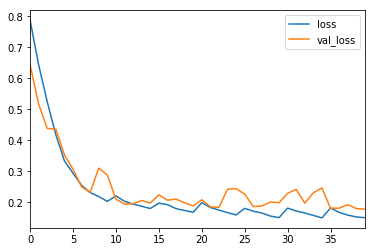

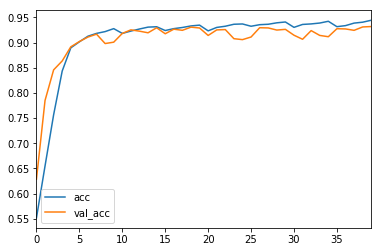

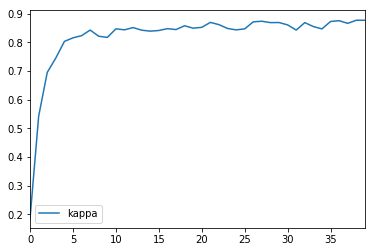

In [ ]:
results[['loss', 'val_loss']].plot()
results[['acc', 'val_acc']].plot()
results[['kappa']].plot()
results.to_csv('model_results.csv',index=False)

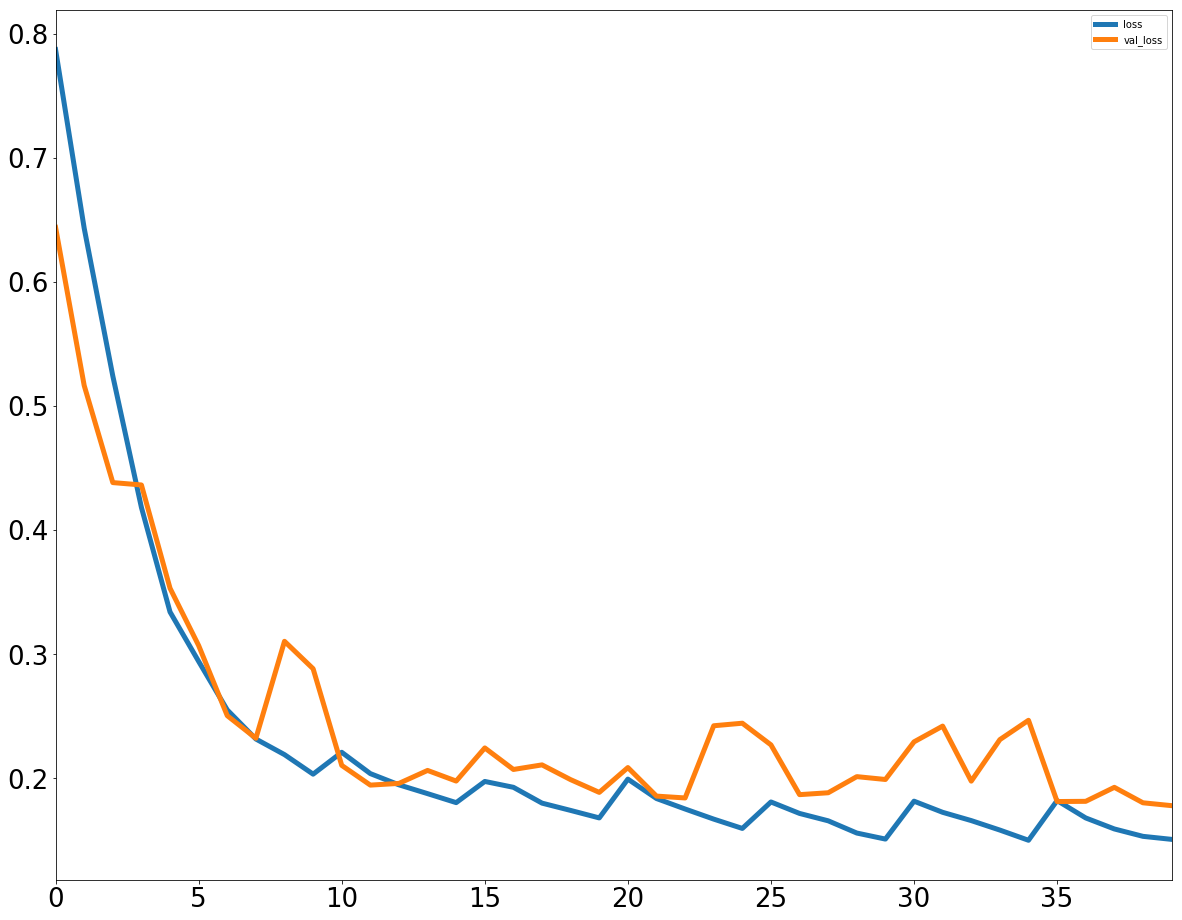

In [ ]:
results[['loss', 'val_loss']].plot(figsize=(20, 16), fontsize=26, linewidth = 5)

plt.savefig('loss_val_loss.png', dpi=300)
plt.savefig('loss_val_loss.eps', dpi=300)


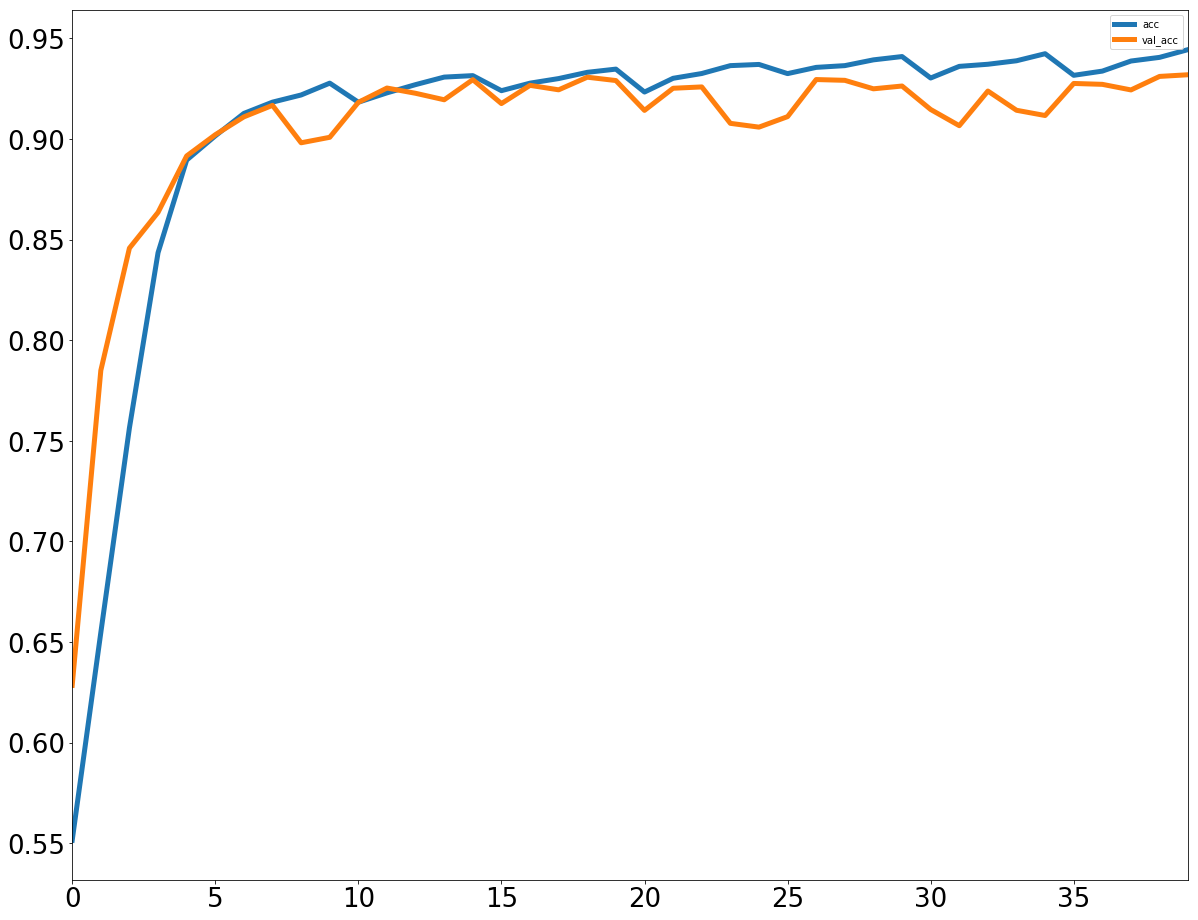

In [ ]:
results[['acc', 'val_acc']].plot(figsize=(20, 16), fontsize=26, linewidth = 5)

plt.savefig('acc_val_acc.png', dpi=300)
plt.savefig('acc_val_acc.eps', dpi=300)

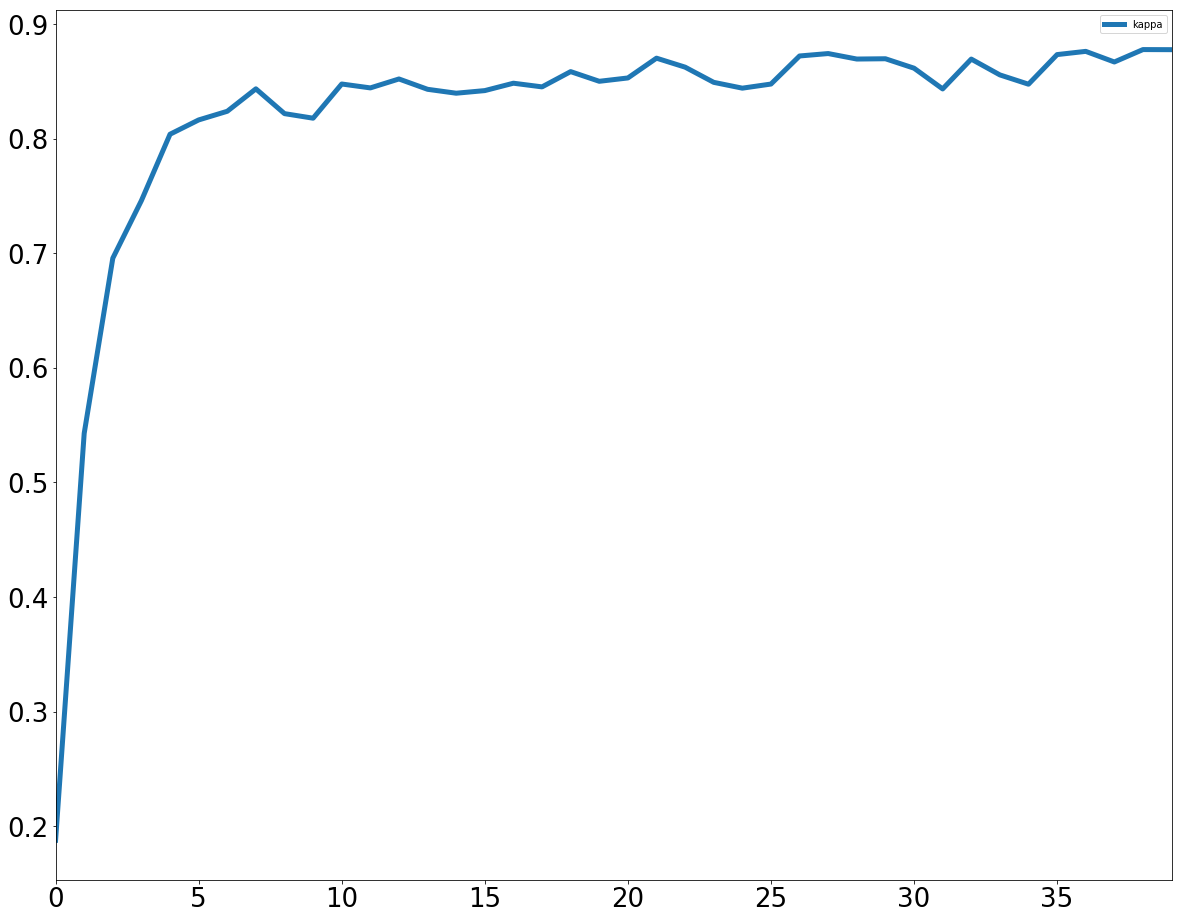

In [ ]:
results[['kappa']].plot(figsize=(20, 16), fontsize=26, linewidth = 5)

plt.savefig('kappa.png', dpi=300)
plt.savefig('kappa.eps', dpi=300)

## Fine Tune with new Data


In [ ]:
model.load_weights('val_model.h5')

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(
    x_val, y_val,
    test_size=0.2,
    random_state=nr_seed
)

gc.collect()

16098

In [ ]:
data_generator = create_datagen().flow(x_train, y_train, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
history = model.fit_generator(
                data_generator,
                steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                epochs=20,
                validation_data=(x_val, y_val),
                callbacks=[kappa_metrics,learn_control,checkpoint]
                )

Epoch 1/20
91/90 [==============================] - 108s 1s/step - loss: 0.1720 - acc: 0.9326 - val_loss: 0.1099 - val_acc: 0.9581
val_kappa: 0.9062
Validation Kappa has improved. Saving model.

Epoch 00001: val_loss improved from 0.17763 to 0.10992, saving model to val_model.h5
Epoch 2/20
91/90 [==============================] - 101s 1s/step - loss: 0.1325 - acc: 0.9469 - val_loss: 0.1034 - val_acc: 0.9584
val_kappa: 0.9033

Epoch 00002: val_loss improved from 0.10992 to 0.10344, saving model to val_model.h5
Epoch 3/20
91/90 [==============================] - 101s 1s/step - loss: 0.1219 - acc: 0.9491 - val_loss: 0.0998 - val_acc: 0.9614
val_kappa: 0.9123
Validation Kappa has improved. Saving model.

Epoch 00003: val_loss improved from 0.10344 to 0.09982, saving model to val_model.h5
Epoch 4/20
91/90 [==============================] - 101s 1s/step - loss: 0.1115 - acc: 0.9533 - val_loss: 0.0959 - val_acc: 0.9634
val_kappa: 0.9139
Validation Kappa has improved. Saving model.

Epoch 0000

In [ ]:
model.save('val_model.h5')

In [ ]:
model.load_weights('val_model.h5')

In [ ]:
res = model.evaluate(x_val, y_val)
print("Testing accuracy : " + str(res[1]))
print("Testing loss : " + str(res[0]))

721/721 [==============================] - 5s 7ms/step
Testing accuracy : 0.9650485458552589
Testing loss : 0.08983408403421407


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y1, y2))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       356
           1       0.48      0.79      0.60        47
           2       0.83      0.74      0.78       232
           3       0.52      0.34      0.41        47
           4       0.61      0.77      0.68        39

    accuracy                           0.84       721
   macro avg       0.68      0.73      0.69       721
weighted avg       0.85      0.84      0.84       721

